In [1]:
import numpy as np
import camb
import matplotlib.pyplot as plt
import time
import multiprocessing as mp

In [2]:
def gauss(m,x):
    #get y=a+b*exp((x-x0)^2/2sig^2)
    a=m[0]
    b=m[1]
    x0=m[2]
    sig=m[3]
    expvec=np.exp(-0.5*(x-x0)**2/sig**2)
    y=a+b*expvec
    derivs=np.empty([len(x),len(m)])
    derivs[:,0]=1
    derivs[:,1]=expvec
    derivs[:,2]=b*(x-x0)/(sig**2)*expvec
    derivs[:,3]=b*(x-x0)**2/sig**3*expvec

    return y,derivs

def fit_newton(m,fun,x,y,niter=10):

    for i in range(niter):
        model,derivs=fun(m,x)
        r=y-model
        lhs=(derivs.T@derivs + lm*I)
        rhs=derivs.T@r
        dm=np.linalg.inv(lhs)@rhs
        m=m+dm
        chisq=np.sum(r**2)
        print('on iteration ',i,' chisq is ',chisq,' with step ',dm)
    return m


def fit_lm(m,fun,x,y,N=None,niter=10,atol=1.e-2,rtol=1.e-6):
    
    def update_lambda(lamda,success):
        if success:
            lamda=lamda/2
            if lamda<0.5:
                lamda=0
        else:
            if lamda==0:
                lamda=1
            else:
                lamda=lamda*2
        return lamda

    lm = 0
    I = np.eye(len(m))
    chisqnew = 0
    if(not N):
        N = np.eye(len(y))
    for i in range(niter):
        model,derivs=fun(m,x)
        r=y-model
        Ninv = np.linalg.inv(N)
        chisq=r.T@Ninv@r
        
        lhs=(derivs.T@Ninv@derivs + lm*I) # first step is always Newton's
        rhs=derivs.T@Ninv@r
        dm = np.linalg.inv(lhs)@rhs
        m_trial = m + dm
        
        model, derivs = fun(m_trial, x)
        r = y-model
        chisqnew = r.T@Ninv@r
        print('on iteration ',i,' chisq is ',chisq,' with step ',dm, 'and lambda ', lm)
        
        if(chisqnew<chisq):
            # accept the new step
            m = m_trial
            lm = update_lambda(lm, True)
            print("step accepted. new m is", m)

            if((np.abs((chisqnew-chisq)/chisq)<rtol)or(np.abs(chisqnew-chisq)<atol) and lm==0):
                # if lm=0, we're in Newton's domain, and fairly close to actual minima
                # Even if chain coverges before lm=0, let the temperature decrease and lm reach 0 before exiting
                print("CHAIN CONVERGED")
                break
        else:
            # stay at the same point but move towards more Gradient descent-ish step
            lm = update_lambda(lm, False)
            print("step rejected. new m is", m)
        
        
    return m


    
    

In [6]:
x=np.linspace(-5,5,1001)
m_true=np.asarray([1,5,0,1])
y_true,derivs=gauss(m_true,x)
y=y_true+np.random.randn(len(x))

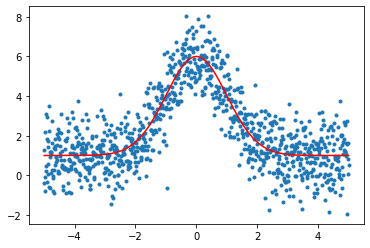

In [24]:
plt.plot(x,y,'.')
plt.plot(x,y_true,'r-')

[ 1.84722331  6.23777072 -0.92699137  1.33450078] init guess vs [1 5 0 1] true guess
on iteration  0  chisq is  6365.258606057964  with step  [-0.9878406  -2.80412064  0.69406731  0.12163752]
on iteration  1  chisq is  1530.59437749141  with step  [ 0.31830072  1.00419856  0.37716043 -0.70180979]
on iteration  2  chisq is  1330.9662728518804  with step  [-0.15174544  0.29957354 -0.1324288   0.24868139]
on iteration  3  chisq is  1083.2859214725333  with step  [-0.05587666  0.23855865 -0.00732156 -0.01913171]
on iteration  4  chisq is  1076.8513683800502  with step  [-5.99954520e-04  6.30549782e-04  6.73022316e-05  1.27408463e-03]
on iteration  5  chisq is  1076.8469412463678  with step  [ 2.68728343e-05  3.91181850e-05  2.35225116e-05 -2.94689487e-05]
on iteration  6  chisq is  1076.8469386865452  with step  [-1.26273734e-06 -1.54264131e-06 -5.43176358e-07  1.31886758e-06]
on iteration  7  chisq is  1076.8469386831791  with step  [ 4.42101052e-08  5.41798527e-08  2.42858868e-08 -4.6200

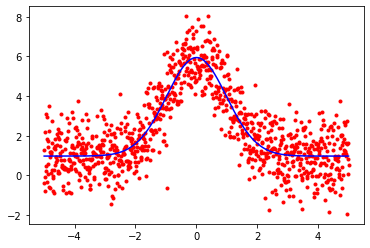

In [48]:
m0 = m_true + np.random.randn(len(m_true))*1.5 # noise in parameter cov sigma = 1.5
print(m0, "init guess vs", m_true, "true guess")
m_fit=fit_newton(m0,gauss,x,y) # newton is horribly wrong if initial guess too far from true
y_fit,derivs=gauss(m_fit,x) 

plt.plot(x,y,'r.')
plt.plot(x,y_fit,'b-')

[-0.84939402  5.75866037 -1.70394837  1.94724118] init guess vs [1 5 0 1] true guess
on iteration  0  chisq is  5379.5206892414035  with step  [ 1.14413524 -3.25450968  1.13939767  0.55192858] and lambda  0
step accepted. new m is [ 0.29474122  2.50415069 -0.5645507   2.49916976]
on iteration  1  chisq is  2563.248651780434  with step  [ 2.87944485 -0.9342929   1.0336864  -4.14632356] and lambda  0
step rejected. new m is [ 0.29474122  2.50415069 -0.5645507   2.49916976]
on iteration  2  chisq is  2563.248651780434  with step  [ 2.56569216 -0.6667646   1.04213349 -3.81374889] and lambda  1
step rejected. new m is [ 0.29474122  2.50415069 -0.5645507   2.49916976]
on iteration  3  chisq is  2563.248651780434  with step  [ 2.31578957 -0.45539386  1.04764934 -3.54659359] and lambda  2
step rejected. new m is [ 0.29474122  2.50415069 -0.5645507   2.49916976]
on iteration  4  chisq is  2563.248651780434  with step  [ 1.94295414 -0.1442041   1.05291984 -3.14254024] and lambda  4
step accepted

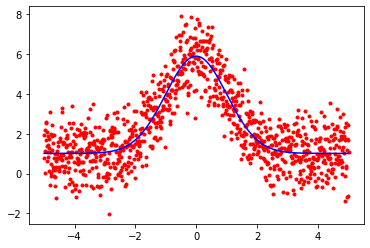

In [8]:
m0 = m_true + np.random.randn(len(m_true))*1.5 # noise in parameter cov sigma = 1.5
print(m0, "init guess vs", m_true, "true guess")
m_fit=fit_lm(m0,gauss,x,y,niter=100)
y_fit,derivs=gauss(m_fit,x) 

plt.plot(x,y,'r.')
plt.plot(x,y_fit,'b-')

In [2]:
def get_spectrum(pars,lmax=3000):
    #print('pars are ',pars)
    H0=pars[0]
    ombh2=pars[1]
    omch2=pars[2]
    tau=pars[3]
    As=pars[4]
    ns=pars[5]
    pars=camb.CAMBparams()
    pars.set_cosmology(H0=H0,ombh2=ombh2,omch2=omch2,mnu=0.06,omk=0,tau=tau)
    pars.InitPower.set_params(As=As,ns=ns,r=0)
    pars.set_for_lmax(lmax,lens_potential_accuracy=0)
    results=camb.get_results(pars)
    powers=results.get_cmb_power_spectra(pars,CMB_unit='muK')
    cmb=powers['total']
    tt=cmb[2:,0]   # monopole and dipole removed
    return tt

def deriv_TT(pars):
    derivs = np.zeros((3049,6))
    delp = [0.05, 0.001, 0.001, 0.0001, 1e-10, 0.01]
    pmat = np.tile(pars,len(pars)).reshape(len(pars),len(pars))
    pmat1 = pmat + delp*np.eye(len(pars))
    pmat2 = pmat - delp*np.eye(len(pars))
    for i in range(len(pars)):
        derivs[:,i] = 0.5*(get_spectrum(pmat1[i,:])-get_spectrum(pmat2[i,:]))/delp[i]
    return derivs
    
    
# ti = time.time()
# modeld = deriv_TT(pars)
# te = time.time()
# print(f"time taken {te-ti:4.2f}s")

In [162]:
def func(a):
    time.sleep(3)
    print(a**2)

In [174]:
    
# ti = time.time()
# results = apply(func,[1,2,3,4])
# te = time.time()
# print(f"time taken {te-ti:4.2f}s")

ti = time.time()
p = mp.Pool(4)
results = [p.apply_async(func, args=(val,)) for val in [1,2,3,4]]
p.join()
p.close()
te = time.time()
print(f"time taken {te-ti:4.2f}s")

AssertionError: 

91164





In [169]:
results

In [3]:
dat = np.loadtxt("../COM_PowerSpect_CMB-TT-full_R3.01.txt", skiprows=1)
y = dat[:,1]

In [6]:
ells = dat[:,0]

In [32]:
ells[2506]

2508.0

In [36]:
model[:2507]

array([795.08939508, 764.03290503, 731.80917065, ...,  95.20811241,
        95.00240314,  94.79490779])

In [37]:
y

array([ 225.895    ,  936.92     ,  692.238    , ..., -149.315007 ,
        -71.4742134,   51.6327312])

In [114]:
row = np.asarray([1,2])



array([[1, 2],
       [1, 2],
       [1, 2],
       [1, 2],
       [1, 2],
       [1, 2]])

In [9]:
pars=np.asarray([69,0.022,0.12,0.06,2.10e-9,0.95])

model=get_spectrum(pars)

In [10]:
err_y = 0.5*(dat[:,2] + dat[:,3])
N = np.eye(len(y))*err_y**2

In [11]:
r = y-model[:len(y)]

In [12]:
r.T@np.linalg.inv(N)@r

3272.203674026268

In [14]:
model=model[:len(y)]
resid=y-model
chisq=np.sum((resid/err_y)**2)

In [15]:
chisq

15267.937674122833

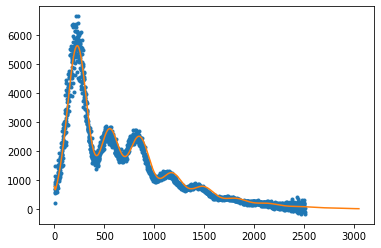

In [38]:

plt.plot(np.arange(2,len(y)+2), y, '.')
plt.plot(np.arange(2,3051), model, '-')
# plt.yscale('log')
# plt.xscale('log')

In [118]:
model.shape

(3049,)

In [16]:
def f(a):
    print(a)

In [14]:
def t(args):
    f(*args)

In [17]:
t((1,))

1
